In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')
# pd.set_option('max_columns', 200)

In [2]:
rmf_df = pd.read_csv('rfm2.csv')
rmf_df

,customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment
0,1,344,1,16.29,1,1,2,112
1,2,196,2,22.77,2,3,2,232
2,3,364,1,10.92,1,1,2,112
3,4,53,2,33.29,3,3,3,333
4,5,180,5,78.82,2,4,4,244
...,...,...,...,...,...,...,...,...
22620,22621,22,1,9.69,4,1,1,411
22621,22622,16,1,6.07,4,1,1,411
22622,22623,11,1,128.01,4,1,4,414
22623,22624,30,1,19.60,4,1,2,412


In [41]:
df = pd.read_csv('merged_df.csv')
df.columns

Index(['id', 'date', 'customer_id', 'transaction_id', 'sku_category', 'sku',
       'quantity', 'sales_amount', 'gender', 'age', 'country'],
      dtype='object')

In [44]:
df[['sku', 'sku_category']].head(10)

,sku,sku_category
0,0EM7L,X52
1,MM3E0,Q4N
2,885U7,X52
3,A59HR,29A
4,7W8WS,L9F
5,6Y6GP,N5F
6,B4KFE,R6E
7,UQC6F,N8U
8,96A0O,X52
9,885U7,X52


<Axes: xlabel='sku_category'>

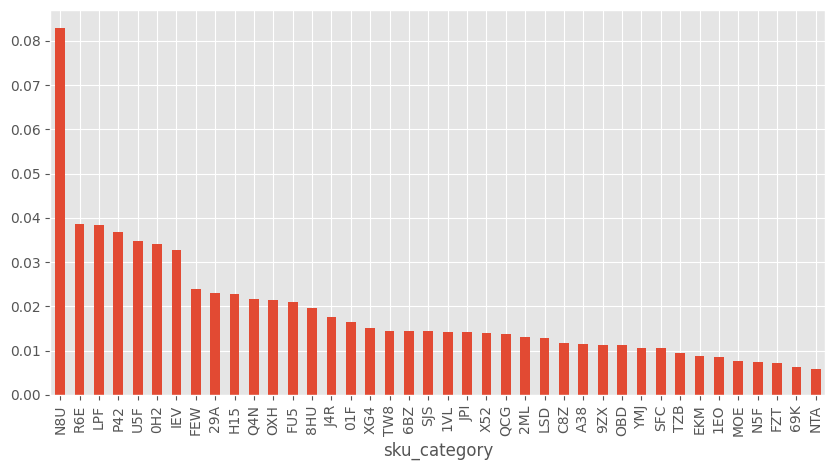

In [51]:
# Example: Count the number of unique SKUs purchased by each customer
sku_count_per_customer = df.groupby('customer_id')['sku'].nunique()

# Example: Calculate the frequency of each SKU category
sku_category_freq = df['sku_category'].value_counts(normalize=True)
sku_category_freq.nlargest(40).plot(kind='bar', figsize=(10,5))



# df.Make.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))



In [4]:
df['date'] = pd.to_datetime(df['date'])
df['quantity'] = df['quantity'].astype(int)
df['sales_amount'] = df['sales_amount'].astype(int)

In [5]:
df = df.sort_values(by=['customer_id', 'date'])
df.head()

,id,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,gender,age,country
19410,7285,2021-01-22,1,3442,0H2,6OUVC,1,10,F,40,UK
19411,7286,2021-01-22,1,3442,N8U,CEBU8,1,5,F,40,UK
54371,29173,2021-03-24,2,14177,TVL,2SLS0,1,7,M,33,Germany
54372,61445,2021-06-19,2,30451,F9B,GZ6VU,1,15,M,33,Germany
900,155,2021-01-02,3,90,LPF,Y1M2E,2,8,F,40,UK


In [6]:
# Calculate the time to next purchase in days for each transaction
df['next_purchase_days'] = df.groupby('customer_id')['date'].shift(-1) - df['date']
df['next_purchase_days'] = df['next_purchase_days'].dt.days

In [7]:
# Define a recency threshold for churn (e.g., 60 days)
recency_threshold = 60

In [8]:
# Apply churn classification
# Transactions with no next purchase or with time to next purchase > threshold are marked as churned
df['is_churned'] = df['next_purchase_days'].apply(lambda x: 1 if x is None or x > recency_threshold else 0)

In [9]:
df['is_churned'].value_counts()

is_churned
0    125614
1      6092
Name: count, dtype: int64

In [ ]:
# Merging the two DataFrames on 'customer_id'
merged_df = pd.merge(df, rmf_df, on='customer_id', how='inner')
merged_df.dtypes

In [12]:
merged_df['Monetary'] = merged_df['Monetary'].astype(int)
merged_df.dtypes

id                             int64
date                  datetime64[ns]
customer_id                    int64
transaction_id                 int64
sku_category                  object
sku                           object
quantity                       int64
sales_amount                   int64
gender                        object
age                            int64
country                       object
next_purchase_days           float64
is_churned                     int64
Recency                        int64
Frequency                      int64
Monetary                       int64
R_Score                        int64
F_Score                        int64
M_Score                        int64
RFM_Segment                    int64
dtype: object

## One hot encoding

In [13]:
categorical_columns = [
    'country',
    'gender'
]

In [14]:
from sklearn.preprocessing import OneHotEncoder

# Selecting categorical columns
cat_features = merged_df[categorical_columns]

# Applying one-hot encoding
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop drop='first' first to avoid multicollinearity
encoded_cat_features = one_hot_encoder.fit_transform(cat_features)

# Converting the encoded features into a DataFrame
encoded_cat_df = pd.DataFrame(encoded_cat_features, 
                              columns=one_hot_encoder.get_feature_names_out(categorical_columns))

# Combining the encoded features with the rest of your data
merged_df = merged_df.drop(categorical_columns, axis=1)
merged_df = pd.concat([merged_df, encoded_cat_df], axis=1)

/home/joao/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
numerical_columns = [
    'quantity', 
    'sales_amount',
    'age',
    'country_Germany',
    'country_Greece',
    'country_Italy',
    'country_Netherlands',
    'country_Spain',
    'country_UK',
    'gender_M'
]

In [ ]:
    'Recency',
    'Frequency',
    'Monetary',
    'R_Score',
    'F_Score',
    'M_Score',
    'quantity', 
    'sales_amount',
    'age',
    'country_Germany',
    'country_Greece',
    'country_Italy',
    'country_Netherlands',
    'country_Spain',
    'country_UK',
    'gender_M'
]

In [22]:
merged_df.columns

Index(['id', 'date', 'customer_id', 'transaction_id', 'sku_category', 'sku',
       'quantity', 'sales_amount', 'age', 'next_purchase_days', 'is_churned',
       'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score',
       'RFM_Segment', 'country_Germany', 'country_Greece', 'country_Italy',
       'country_Netherlands', 'country_Spain', 'country_UK', 'gender_M'],
      dtype='object')

<Axes: >

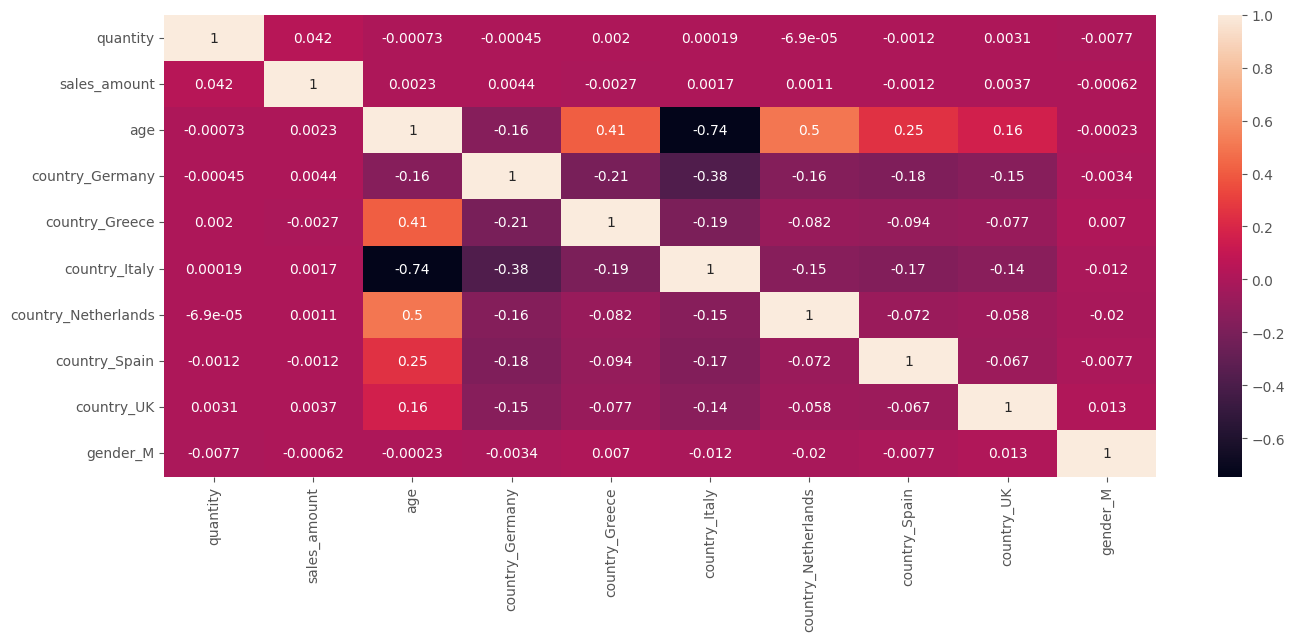

In [33]:
plt.figure(figsize=(16, 6))

sns.heatmap(merged_df[numerical_columns].corr(), annot=True)            

# Linear regression

In [ ]:
feature_names = numerical_columns
features = merged_df[feature_names]
target = merged_df['is_churned']